# Generate training set

Real-time Deep Neural Networks for Microphone Array Direction of Arrival Estimation

This research uses the CMU_ARCTIC database, which is a speech database in CMU_ARCTIC speech synthesis databases, established by the Language Technologies Institute of Carnegie Mellon University, USA. This database is mainly used in the research of speech synthesis. The content of the corpus database was selected by the non-copyright center of Project Gutenberg, which is about 1150 sentences. An audio of two males and two females with American English accents were collected. The recording format is 16 bits, the sampling rate is 32 KHz, and the length of each sentence is 3 seconds. The database has a total of 4528 audio files.

## Imports

In [6]:
import math
import sys
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize
from pyroomacoustics.transform import stft

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler

## Constants

In [7]:
# Label resolution of angles
RESOLUTION = 15

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

AUDIO_PATH = 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\training'

# Number of microphones
MICS_NUMBER = 2
MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

## Classes to store signals

In [8]:
class RIR():
    def __init__(self, room, source, angle, distance, mic_nr, src_nr):
        self.name = source + '-' + str(distance) + '-' + str(angle * 180. * np.pi)
        self.room = room
        self.source = source
        self.angle = angle
        self.distance = distance

        # Check validity of the room
        self.room.simulate()
        

    def getSignals(self):
        # Extract simulated signal for each microphone
        data = self.room.mic_array.signals.T
        data = np.array(normalize(data, bits=16), dtype=np.int16)

In [9]:
# Dataset

class SimulatedRIR():
    def __init__(self, dataset):
        self.dataset = dict()

    def addRIR(self, RIR):
        self.dataset[RIR.name] = RIR

    def removeRIR(self, RIR):
        self.dataset.pop(RIR.name)

    def data(self):
        return self.dataset

## Definition for rooms, microphones and sources

In [10]:
def create_simulation_room(room_dim=[4, 4, 3], mic_pos=[2, 2, 1.5], room_fs=16000):    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs)
    w = room_dim[0]
    l = room_dim[1]
    h = room_dim[2]

    # Generate the microphones
    mic_loc = np.c_[[w/2+0.2, l/2, h/2],[w/2-0.2, l/2, h/2]] 
    room.add_microphone_array(mic_loc)
    
    return room


def create_sound_sources(room_dim=[4, 4, 3], resolution=15):        
    # Specify angle in distance ranges
    angle_range = range(0, 360, resolution)
    dist_range = [1., 2.]
    height_range = [room_dim[-1]/2]
    sources = defaultdict(list)

    for angle in angle_range:
        for R in dist_range:
            for h in height_range:
                source = [R * math.cos(math.radians(angle)) + room_dim[0] / 2, 
                            R * math.sin(math.radians(angle)) + room_dim[0] / 2, h]
                sources[angle].append((R, h, source))
    return sources


def simulate_room(audio_file, subset, room_type='small', mic_pos=[2, 2, 1.5], label_res=20):
    file_name = os.path.basename(audio_file).split('.')[0]
    
    # Read the audio file
    fs, audio = wavfile.read(audio_file)

    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        room_dim = TEST_ROOMS[room_type]

    # Create all sound sources
    sources = create_sound_sources(room_dim, 15)

    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'\nSimulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        wav_signals = defaultdict(list)
        
        for dist, height, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
            room.add_source(source, signal=audio, delay=0.0)
            room.simulate()

            # Extract simulated signal for each microphone
            data = room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            
            # Append simulated data to the final WAV signals
            wav_signals[dist].extend(data)
            
        # Save WAV files containing 2 channel data for all distances at given angle
        for dist in wav_signals:
            save_name = f'{subset}_angle_{angle}_dist_{int(dist*100)}_room_{room_type}_{file_name}.wav'
            wavfile.write(f'{AUDIO_PATH}/{save_name}', fs, np.array(wav_signals[dist]))
        
        if angle % label_res == label_res - 1:
            print(' Done.')
            
    print('\nSimulation successful!')

## Run simulations

In [12]:
for room, dim in ROOMS.items():
    # Call the function above and store all results
    print(f'\nRoom: {room}')
    sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0010.wav"
    #simulate_room(sound_files, 'train', room, dim / 2, label_res=60)


Room: small

Simulating 0-59 degrees: ####
Simulating 60-119 degrees: ####
Simulating 120-179 degrees: ####
Simulating 180-239 degrees: ####
Simulating 240-299 degrees: ####
Simulating 300-359 degrees: ####
Simulation successful!

Room: medium

Simulating 0-59 degrees: ####
Simulating 60-119 degrees: ####
Simulating 120-179 degrees: ####
Simulating 180-239 degrees: ####
Simulating 240-299 degrees: ####
Simulating 300-359 degrees: ####
Simulation successful!

Room: large

Simulating 0-59 degrees: ####
Simulating 60-119 degrees: ####
Simulating 120-179 degrees: ####
Simulating 180-239 degrees: ####
Simulating 240-299 degrees: ####
Simulating 300-359 degrees: ####
Simulation successful!


## Check output

In [14]:
fs, audio = wavfile.read(f'{AUDIO_PATH}/train_angle_0_dist_100_room_large_arctic_a0010.wav')
cols = [f'mic_{i}' for i in range(2)]
df = pd.DataFrame(data=audio, columns=cols, dtype=np.int16)
df.iloc[2000:2005]

,mic_0,mic_1
2000,-138,56
2001,-138,32
2002,-138,-4
2003,-135,-40
2004,-138,-68


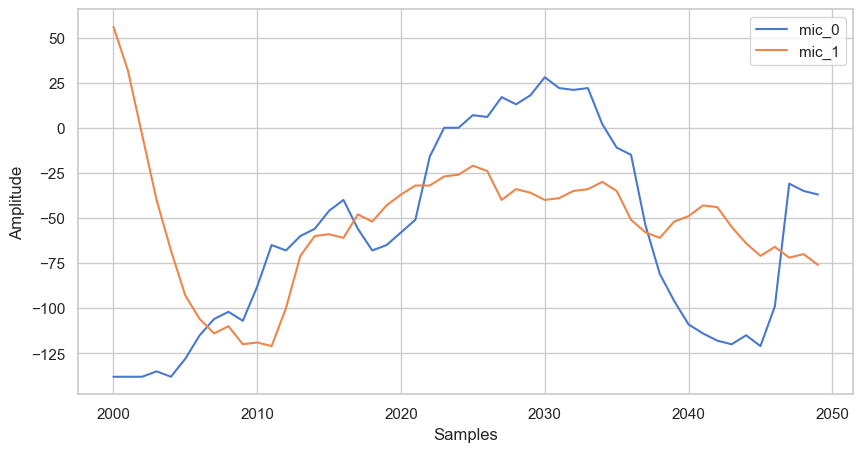

In [15]:
sns.set(style='whitegrid', palette='muted', font_scale=1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
df.iloc[2000:2050].plot(ax=ax)
plt.show()

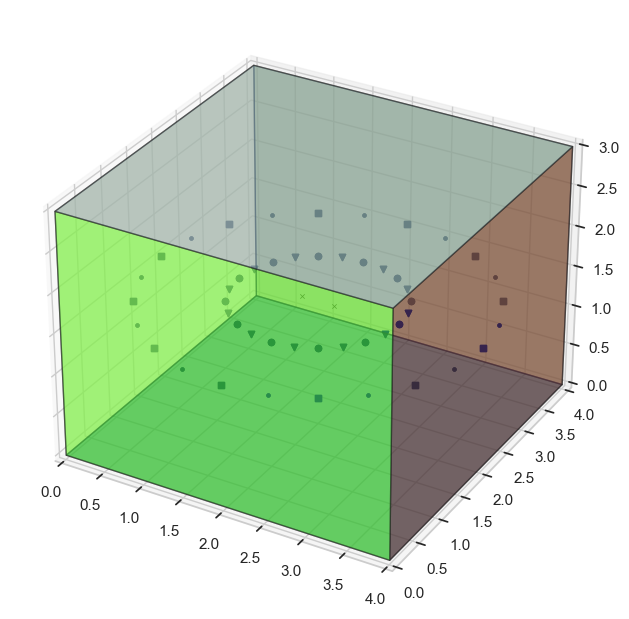

In [16]:
room_dim = ROOMS['small']

room = create_simulation_room(room_dim, mic_pos=room_dim / 2)
sources = create_sound_sources(room_dim, resolution=15)

def plot_room(room, sources):
    fs, audio = wavfile.read("C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0010.wav")

    # Add every single source to the room
    for angle, sources in sources.items():
        for _, _, source in sources:
            room.add_source(source, signal=audio, delay=0.5)

    # Plot the room
    fig, ax = room.plot()
    fig.set_size_inches(6, 6)
    ax.set_xlim([0, room_dim[0]])
    ax.set_ylim([0, room_dim[1]])
    ax.set_zlim([0, room_dim[2]])
    
plot_room(room, sources)

## Creating training and testing datasets

In [4]:
def gcc_phat(x_1, x_2, FS=16000, interp=1):    
    n = len(x_1) + len(x_2) - 1
    n += 1 if n % 2 else 0
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
    # Normalize by the magnitude of FFT - because PHAT
    np.divide(X_1, np.abs(X_1), X_1, where=np.abs(X_1) != 0)
    np.divide(X_2, np.abs(X_2), X_2, where=np.abs(X_2) != 0)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    cc = np.fft.irfft(CC, n=n * interp)
        
    # Maximum delay between a pair of microphones,
    # expressed in a number of samples.
    # 0.09 m is the mic array diameter and 
    # 340 m/s is assumed to be the speed of sound.
    max_len = math.ceil(0.09 / 340 * FS * interp)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc


def one_hot_encode(encoder, y_train, y_test):    
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # One-hot encode training and testing labels
    enc = encoder.fit(y_train)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)
    
    return y_train, y_test


def compute_gcc_matrix(observation, fs, interp=1):
    """
    Creates a GCC matrix, where each row is a vector of GCC 
    between a given pair of microphones.
    """ 
    
    mic_pairs = combinations(range(MICS_NUMBER), r=2)

    # Initialize a transformed observation, that will be populated with GCC vectors
    # of the observation
    transformed_observation = []

    # Compute GCC for every pair of microphones
    for mic_1, mic_2 in mic_pairs:
        x_1 = observation[:, mic_1]
        x_2 = observation[:, mic_2]

        gcc = gcc_phat(x_1, x_2, FS=fs, interp=interp)

        # Add the GCC vector to the GCC matrix
        transformed_observation.append(gcc)    
        
    return transformed_observation



def create_observations(wav_signals, fs, label, samples=1, step=1, resolution=20, music=False, interp=1):
    # Lists of observations and labels that will be populated
    X = []
    y = []
    rounded_label = round(label / resolution) * resolution
    if rounded_label == 360: rounded_label = 0
    
    # Loop through the signal frame and take subframes
    for i in range(0, len(wav_signals) - samples + 1, step):
        y.append(rounded_label)
        
        # Extract the observation from subframe
        observation = np.array(wav_signals[i : i + samples])
        
        if music:
            # Transform observation into a STFT matrix
            transformed_observation = compute_stft_matrix(observation)
        else:
            # Transform observation into a GCC matrix
            transformed_observation = compute_gcc_matrix(observation, fs, interp=interp)
            
        X.append(transformed_observation)

    return X, y



def create_dataframe(subset, samples=20, step=5, resolution=20, interp=1):
    dataframes = []
    files = [f for f in os.listdir(AUDIO_PATH) if os.path.isfile(os.path.join(AUDIO_PATH, f))]

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav':
            continue
    
        print(f'{subset} file {i+1}/{len(files)}', end='\r')
        path = os.path.join(AUDIO_PATH, file)
        fs, wav_signals = wavfile.read(path)

        label = int(file.split('_')[2])

        # Create observations from a given WAV file
        X_temp, y_temp = create_observations(wav_signals, fs, label, samples, step, resolution, interp=interp)

        cols = [
                f'mics{mic_1+1}{mic_2+1}_{i}' 
                    for mic_1, mic_2 in combinations(range(MICS_NUMBER), r=2) 
                        for i in range(np.shape(X_temp)[2])
            ]

        df = pd.DataFrame(data=np.reshape(X_temp, (len(X_temp), -1)), columns=cols)
        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        df['dist'], df['room'] = dist, room
            
        # Add label column
        df['label'] = y_temp
        dataframes.append(df)
        
    return pd.concat(dataframes, ignore_index=True)


def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    """
    Creates an entire dataset by extracting values from train and tests dataframes.
    One-hot encodes the labels before returning.
    """
    
    # Can filter testing entries to only check performance
    # for given conditions
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_train), MIC_COMBS, -1)
    X_test = df_test.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_test), MIC_COMBS, -1)
    
    # Create train/test labels
    y_train, y_test = one_hot_encode(
        encoder, df_train['label'].values, df_test['label'].values)
    
    return X_train, y_train, X_test, y_test

In [27]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()

df_train.to_csv('../training_data/azimuth_train_dataset.csv')
df_test.to_csv('../training_data/azimuth_test_dataset.csv')

# Create numpy arrays with observations and one-hot labels
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)

print(np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))
pd.set_option('display.max_columns', 15)
df_train.head(10)

train file 144/144
test file 144/144
(8208, 1, 11) (8208, 1, 11) (8208, 24) (8208, 24)


,mics12_0,mics12_1,mics12_2,mics12_3,mics12_4,mics12_5,mics12_6,mics12_7,mics12_8,mics12_9,mics12_10,dist,room,label
0,0.025816,-0.005872,0.020369,0.035299,0.019479,0.036945,0.022900,0.014530,0.021019,-0.004756,0.005340,100,large,0
1,-0.013978,0.089037,-0.056747,0.020586,-0.195281,0.401329,-0.197708,0.113935,0.059565,-0.046805,-0.119631,100,large,0
2,-0.011097,0.033917,-0.028638,0.057426,-0.110789,0.126031,-0.117461,0.067885,-0.036614,0.030661,-0.039578,100,large,0
3,-0.028778,0.019381,-0.040585,0.051745,-0.093423,0.141871,-0.132199,0.064355,-0.020604,0.029927,-0.038607,100,large,0
4,0.046493,-0.002961,0.022353,0.114092,-0.128367,0.245182,-0.231861,0.030220,-0.019942,-0.049130,-0.056103,100,large,0
5,0.001133,0.027092,-0.006202,0.107668,-0.006674,0.200646,-0.046819,0.093875,-0.043653,0.002451,-0.034416,100,large,0
6,-0.083440,-0.030771,-0.025750,0.127903,0.071652,0.294306,-0.103915,-0.037334,-0.205717,-0.122204,-0.106367,100,large,0
7,0.099263,-0.018728,0.012936,0.006222,0.114125,-0.118416,0.084031,-0.024798,0.017785,-0.098817,0.115509,100,large,0
8,0.034894,-0.019080,0.005607,-0.016857,0.026728,-0.033282,-0.006958,-0.016327,-0.017708,-0.029558,-0.008514,100,large,0
9,0.030927,0.037692,-0.019202,0.053000,0.027708,0.024890,-0.026810,0.098943,-0.036661,-0.023930,-0.011540,100,large,0


In [11]:
df_train = pd.read_csv('../training_data/azimuth_train_dataset.csv', index_col=[0])
df_test = pd.read_csv('../training_data/azimuth_test_dataset.csv', index_col=[0])
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoder.fit([[label] for label in df_train['label']])
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((8208, 1, 11), (8208, 1, 11), (8208, 24), (8208, 24))

In [16]:
def compute_stft_matrix(observation, nfft=256):
    """
    Creates a STFT matrix using microphone data from 6 channels.
    """
    
    # Default value for overlap
    step = nfft // 2
    
    # Calculate multidimensional STFT and return
    transformed_observation = stft.analysis(observation, L=nfft, hop=step)
    return np.transpose(transformed_observation, axes=[2, 1, 0])


def get_music_prediction(X, mic_pos=[2, 2, 1], resolution=20, fs=16000, nfft=256):
    """
    Calculates DOA based on MUSIC prediction.
    Returns:
        an angle in degrees in range 0-360 with resolution of 20
    """
    
    # Declare microphone array position
    mic_center = mic_pos[:2]
    mic_height = mic_pos[-1]
    
    # Radius constant, will always be the same for MiniDSP array
    mic_radius = 0.045

    # Generate the microphone array
    R = pra.circular_2D_array(center=mic_center, M=6, phi0=0, radius=mic_radius)
    R = np.vstack((R, [mic_height] * 6))
    
    # Run MUSIC algorithm for DOA
    doa = pra.doa.MUSIC(R, fs, nfft, n_grid=(360 // resolution), dim=3)
    doa.locate_sources(X)
    
    return round((doa.azimuth_recon[0] * 180 / math.pi))
  


def get_all_predictions(is_info=False, samples=20, step=5, resolution=20):
    """
    Returns a list of labels predicted by applying MUSIC.
    Observations are generated from the same test files
    that are used for CNN classification.
    
    Observation is a matrix of size (samples, channels), where
    channels is the number of microphones (6).
    """
    
    y_true = []
    y_pred = []
    info = []
    
    files = [file for file in os.listdir(AUDIO_PATH) if 'test' in file]
    
    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue

        path = os.path.join(AUDIO_PATH, file)
        fs, wav_signals = wavfile.read(path)
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X, y = create_observations(wav_signals, fs, label, samples, step, resolution, True)

        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        y = [(dist, room, label) for label in y]
           
        # Store actual and predicted labels
        y_true.extend(y)
        preds = [get_music_prediction(x, resolution=resolution, fs=fs) for x in X]
        y_pred.extend(preds)
        
        print(f'File {i+1}/{len(files)}', end='\r')
       
    y_true = np.array(y_true)
    
    info = y_true[:, :-1]
    y_true = list(y_true[:, -1].astype(int))
    return y_true, y_pred, info

In [17]:
# Run MUSIC prediction on the data set
y_true, y_pred, info = get_all_predictions(True, samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print(np.shape(y_true), np.shape(y_pred))

# Plot confusion matrix and report accuracy
plot_cm(y_true, y_pred, np.unique(y_true))
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {round(accuracy, 3)}')
print(f'RMSE: {rmse(y_true, y_pred)}')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed